In [1]:
import json
import numpy as np
import pandas as pd
import re
import string
import scipy
import time
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer,LineTokenizer
from nltk.stem import LancasterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


In [2]:
video_df = pd.read_csv("./video_data.csv")
print("Total number of videos : ",len(video_df))

Total number of videos :  5585


In [3]:
video_df.columns

Index(['video_id', 'category_name', 'short_description', 'story_text',
       'title'],
      dtype='object')

In [4]:
print(video_df.category_name.unique())
print(len(video_df.category_name.unique()))

['Entertainment News' 'India News' 'Karnataka Elections 2018' 'World News'
 'Sports News' 'Business News' 'R Bharat' 'Initiatives' 'Technology News'
 'Lifestyle']
10


In [5]:
video_df["description"] = video_df["title"]+" "+video_df["short_description"]+" "+video_df["story_text"]

In [6]:
def clean(x):
    temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', x)
    temp = re.sub("[^a-zA-Z]", " ", temp)
    temp = re.sub(' +', ' ', temp).lower()
    return temp

In [7]:
video_df["description_cleaned"] = video_df["description"].map(clean)

In [8]:
import numpy as np
import pandas as pd
np.random.seed(1)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

topics = range(6, 17, 1)
perplexities = list()
loglikelihood = list()
lda_list = list()
vec = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=15000,
                                stop_words='english')
tf = vec.fit_transform(video_df["description_cleaned"])

for i in topics:
    print('Computing perplexity and log likelihood for #topics: {}'.format(i))
    lda = LatentDirichletAllocation(n_components=i, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
    
    lda.fit(tf)
    perplexities.append(np.log(lda.perplexity(tf)))
    loglikelihood.append(lda.score(tf))
    lda_list.append(lda)



Computing perplexity and log likelihood for #topics: 6
Computing perplexity and log likelihood for #topics: 7
Computing perplexity and log likelihood for #topics: 8
Computing perplexity and log likelihood for #topics: 9
Computing perplexity and log likelihood for #topics: 10
Computing perplexity and log likelihood for #topics: 11
Computing perplexity and log likelihood for #topics: 12
Computing perplexity and log likelihood for #topics: 13
Computing perplexity and log likelihood for #topics: 14
Computing perplexity and log likelihood for #topics: 15
Computing perplexity and log likelihood for #topics: 16


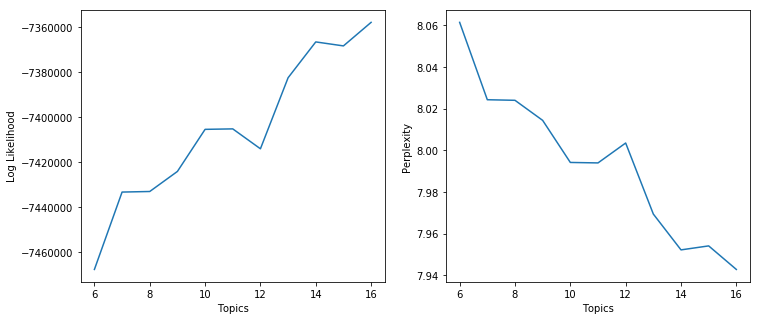

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(topics,loglikelihood)
plt.xlabel('Topics')
plt.ylabel('Log Likelihood')
plt.subplot(1, 2, 2)
plt.plot(topics,perplexities)
plt.xlabel('Topics')
plt.ylabel('Perplexity')
plt.show()

In [10]:
best_lda = lda_list[np.argmin(perplexities)]

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [12]:
print("\nTopics in LDA model:")
tf_feature_names = vec.get_feature_names()
print_top_words(best_lda, tf_feature_names, 10)


Topics in LDA model:
Topic #0: court delhi said police chief supreme mumbai students board hospital
Topic #1: said minister india congress modi government party pakistan prime bjp
Topic #2: shared post sharma khan kapil instagram picture actor pm pst
Topic #3: india cricket team said match indian series kohli test year
Topic #4: twitter khan pic com march april wedding hai salman kapoor
Topic #5: sridevi kapoor dubai bollywood actor family janhvi february actress death
Topic #6: republic case tv said police bjp accused watch video minister
Topic #7: statue ambedkar ronaldo indigo tripura mukherjee kolkata putin cristiano madrid
Topic #8: said new world year india company time facebook air users
Topic #9: tamil nadu rajinikanth kamal haasan water chennai cauvery political tmc
Topic #10: salman khan case court jail jodhpur actor alia poaching blackbuck
Topic #11: rs crore bank nirav ipl modi punjab auction players kings
Topic #12: gold india games women commonwealth world medal event in

In [13]:
result = best_lda.transform(tf)
a = np.argwhere(result >= 0.1)
n = range(tf.shape[0])
val1 = [ list(a[a[:,0]==i,1]) for i in n] 
val2 = np.argpartition(-result, 11)[:,0:11]
val = pd.Series(list(zip(val1,val2))).map(lambda x:list(set.intersection(set(x[0]),set(x[1]))))
video_df["topic_list"] = list(val)

In [14]:
video_df.head(4)

,video_id,category_name,short_description,story_text,title,description,description_cleaned,topic_list
0,5653616771001,Entertainment News,The 34-year-old actor is not sure if he's goin...,Hack: \tThe 34-year-old actor is not sure if h...,Adam Driver still 'undecided' on seeing 'Star ...,Adam Driver still 'undecided' on seeing 'Star ...,adam driver still undecided on seeing star war...,"[2, 13]"
1,5631919940001,Entertainment News,The poster gives us a closer look at the actor...,The latest poster of 2.0 featuring Bollywood s...,"BEWARE: Akshay Kumar's look from 2.0 is out, a...","BEWARE: Akshay Kumar's look from 2.0 is out, a...",beware akshay kumar s look from is out and it ...,"[5, 13]"
2,5767901401001,India News,A massive outrage has erupted over the horrifi...,A massive outrage has erupted over the horrifi...,Kathua-Rape-Murder Case: Protesters demand CBI...,Kathua-Rape-Murder Case: Protesters demand CBI...,kathua rape murder case protesters demand cbi ...,"[1, 6]"
3,5741125480001,India News,"According to forensic report, traces of alcoho...",The mystery surrounding Sridevi’s passing away...,Sridevi’s death: Here’s what Amar Singh claims...,Sridevi’s death: Here’s what Amar Singh claims...,sridevi s death here s what amar singh claims ...,"[5, 6]"


In [15]:
video_df["topic_list"].map(lambda x: len(x)).value_counts()



2    2274
3    1476
1    1249
4     426
0      96
5      64
Name: topic_list, dtype: int64

In [16]:
video_df.topic_list.map(lambda x:len(x)).max()

5

In [17]:
x_df = video_df[["video_id","topic_list","category_name"]].head(10)

In [18]:
x_df

,video_id,topic_list,category_name
0,5653616771001,"[2, 13]",Entertainment News
1,5631919940001,"[5, 13]",Entertainment News
2,5767901401001,"[1, 6]",India News
3,5741125480001,"[5, 6]",India News
4,5746648010001,"[1, 13]",Entertainment News
5,5681785257001,"[0, 4, 5, 6]",India News
6,5741917141001,[5],Entertainment News
7,5624410256001,"[0, 1, 3]",India News
8,5631826036001,"[11, 6, 7]",India News
9,5766859240001,"[1, 4, 6]",India News


In [19]:
x_df

,video_id,topic_list,category_name
0,5653616771001,"[2, 13]",Entertainment News
1,5631919940001,"[5, 13]",Entertainment News
2,5767901401001,"[1, 6]",India News
3,5741125480001,"[5, 6]",India News
4,5746648010001,"[1, 13]",Entertainment News
5,5681785257001,"[0, 4, 5, 6]",India News
6,5741917141001,[5],Entertainment News
7,5624410256001,"[0, 1, 3]",India News
8,5631826036001,"[11, 6, 7]",India News
9,5766859240001,"[1, 4, 6]",India News


In [20]:
def generate_parent_list(df):

    df['video_id_parent_list'] = list(zip(df["topic_list"], df["video_id"]))
    df['topic_parent_list'] = list(zip(df["category_name"], df["topic_list"]))

    node_dict = dict()
    for tup in df["video_id_parent_list"]:
        node_dict[tup[1]] = tup[0]
        
    for tup in df["topic_parent_list"]:
        for topic in tup[1]:
            if topic in node_dict:
                temp_list = node_dict[topic]
                temp_list.append(tup[0])
                node_dict[topic] = list(set(temp_list))
            else:
                node_dict[topic] = [tup[0]]
    
    return node_dict

def generate_node_list(df):
    video_ids = list(df["video_id"])
    flatten = lambda l: [item for sublist in l for item in sublist]
    topics = list(set(flatten(df["topic_list"])))
    categories = list(set(df["category_name"]))
    node_list = video_ids+topics+categories
    return node_list

def generate_structure(parent_dict,node_list):
    structure = list()
    for node in node_list:
        if node in parent_dict:
            parents = parent_dict[node]
            parent_indices = [node_list.index(val) for val in parents]
            res = tuple(parent_indices)
        else:
            res = ()
        structure.append(res)
    return structure
    

In [22]:
parent_dict = generate_parent_list(video_df)
node_list = generate_node_list(video_df)
structure = generate_structure(parent_dict,node_list)
node_list = [str(node) for node in node_list]

In [23]:
parent_dict

{5653616771001: [2, 13],
 5631919940001: [5, 13],
 5767901401001: [1, 6],
 5741125480001: [5, 6],
 5746648010001: [1, 13],
 5681785257001: [0, 4, 5, 6],
 5741917141001: [5],
 5624410256001: [0, 1, 3],
 5631826036001: [11, 6, 7],
 5766859240001: [1, 4, 6],
 5772429857001: [2, 13],
 5750242001001: [13, 6],
 5762369674001: [0, 2, 4, 13],
 5721105470001: [1, 10, 13, 6],
 5766907589001: [13],
 5737096976001: [1, 11, 6],
 5740587338001: [5, 6],
 5753611686001: [2, 3, 4],
 5771785936001: [10],
 5727893861001: [2],
 5749229433001: [4, 13],
 5737628568001: [1, 13],
 5774696173001: [1, 11, 6, 15],
 5770258437001: [2, 13, 15],
 5663160532001: [1, 4, 12],
 5761741401001: [1, 5, 13, 6],
 5663182667001: [15],
 5726393456001: [3],
 5736489331001: [2, 13],
 5768779884001: [3, 9, 11],
 5751110129001: [13, 15],
 5770307769001: [1],
 5739781874001: [6, 14],
 5770244518001: [6],
 5774268897001: [9, 6],
 5634271926001: [0, 1, 13],
 5760976409001: [2, 14],
 5758859809001: [0, 1],
 5622401775001: [1, 6],
 57

In [24]:
df.topic_list.map(lambda x:len(x)).max()

5

In [25]:
len(structure)

5611

In [26]:
len(node_list)

5611

In [27]:
import numpy as np
from pomegranate import *

def generate_matrix_with_shape( m, n):
    x = np.random.randint(10, size=(m*n-n))
    y = np.array([1 if i<2 else 0 for i in x])
    z = y.reshape((m-1,n))
    result = np.vstack((z,np.ones((1,n))))
    return result
t0=time.time()
matrix = generate_matrix_with_shape(100, len(node_list))

pgm_model = BayesianNetwork.from_structure(matrix, structure=structure,
                                       state_names=node_list)
time.time()-t0

28.088470935821533

In [53]:
pgm_model.to_json("./pgm.json")

ValueError: too many values to unpack (expected 2)

In [28]:
node_list

['5653616771001',
 '5631919940001',
 '5767901401001',
 '5741125480001',
 '5746648010001',
 '5681785257001',
 '5741917141001',
 '5624410256001',
 '5631826036001',
 '5766859240001',
 '5772429857001',
 '5750242001001',
 '5762369674001',
 '5721105470001',
 '5766907589001',
 '5737096976001',
 '5740587338001',
 '5753611686001',
 '5771785936001',
 '5727893861001',
 '5749229433001',
 '5737628568001',
 '5774696173001',
 '5770258437001',
 '5663160532001',
 '5761741401001',
 '5663182667001',
 '5726393456001',
 '5736489331001',
 '5768779884001',
 '5751110129001',
 '5770307769001',
 '5739781874001',
 '5770244518001',
 '5774268897001',
 '5634271926001',
 '5760976409001',
 '5758859809001',
 '5622401775001',
 '5760918864001',
 '5693167325001',
 '5668544875001',
 '5735147394001',
 '5760976442001',
 '5641395697001',
 '5766898216001',
 '5740052577001',
 '5739024974001',
 '5773720283001',
 '5737117839001',
 '5743753377001',
 '5720667369001',
 '5758820153001',
 '5738411530001',
 '5632970548001',
 '56579937

In [40]:
observations = { '5653616771001' : 1, '5767901401001' : 1}

In [49]:
t0=time.time()
result = pgm_model.predict_proba(observations,max_iterations=2)
time.time()-t0

401.64298391342163

In [50]:
result[i]

{
    "class" :"Distribution",
    "dtype" :"numpy.float64",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "1.0" :0.2496999295559675,
            "0.0" :0.7503000704440326
        }
    ],
    "frozen" :false
}

In [51]:
res_dict = dict()
for i in range(len(node_list)):
    if node_list[i] not in observations:
        val = result[i].values()[1]
        if val >0.5:
            res_dict[node_list[i]] = val

In [52]:
res_dict

{'5770725839001': 0.5751831149368534,
 '5749659906001': 0.5587383894849607,
 '5755390239001': 0.5412479342450476,
 '5748130948001': 0.5128374803872886,
 '5719170858001': 0.5449492134630753,
 '5698623820001': 0.7999999999999999,
 '5738545638001': 0.7499999999999999,
 '5663180535001': 0.5092021576938585,
 '5744682189001': 0.596302734395475,
 '5694700346001': 0.5078045916981085,
 '5739673606001': 0.5231255626673955,
 '5629685174001': 0.5567450047891033,
 '5738370737001': 0.5115564071096531,
 '5681206690001': 0.5005134305385164,
 '5749634431001': 0.7899999999999999,
 '5688024380001': 0.5673590981737991,
 '5737087805001': 0.5953647216130257,
 '5713421329001': 0.5195143240460381,
 '5758851751001': 0.5189710109363448,
 '5734273971001': 0.5131089375471904,
 '5742986512001': 0.5342330422374735,
 '5698610532001': 0.7999999999999999,
 '5744369731001': 0.5200291807119511,
 '5727902503001': 0.8599999999999998,
 '5653488977001': 0.5151185880120529,
 '5745839300001': 0.5419945206647505,
 '56416698140

In [39]:
video_df

,video_id,category_name,short_description,story_text,title,description,description_cleaned,topic_list
0,5653616771001,Entertainment News,The 34-year-old actor is not sure if he's goin...,Hack: \tThe 34-year-old actor is not sure if h...,Adam Driver still 'undecided' on seeing 'Star ...,Adam Driver still 'undecided' on seeing 'Star ...,adam driver still undecided on seeing star war...,"[2, 13]"
1,5631919940001,Entertainment News,The poster gives us a closer look at the actor...,The latest poster of 2.0 featuring Bollywood s...,"BEWARE: Akshay Kumar's look from 2.0 is out, a...","BEWARE: Akshay Kumar's look from 2.0 is out, a...",beware akshay kumar s look from is out and it ...,"[5, 13]"
2,5767901401001,India News,A massive outrage has erupted over the horrifi...,A massive outrage has erupted over the horrifi...,Kathua-Rape-Murder Case: Protesters demand CBI...,Kathua-Rape-Murder Case: Protesters demand CBI...,kathua rape murder case protesters demand cbi ...,"[1, 6]"
3,5741125480001,India News,"According to forensic report, traces of alcoho...",The mystery surrounding Sridevi’s passing away...,Sridevi’s death: Here’s what Amar Singh claims...,Sridevi’s death: Here’s what Amar Singh claims...,sridevi s death here s what amar singh claims ...,"[5, 6]"
4,5746648010001,Entertainment News,After her national award winning first film 'N...,After her national award winning first film 'N...,Churni's next film on social media affecting p...,Churni's next film on social media affecting p...,churni s next film on social media affecting p...,"[1, 13]"
5,5681785257001,India News,A minor boy committed suicide in this Bihar di...,A minor boy committed suicide in this Bihar di...,"Bihar: Forced to marry widowed sister-in-law, ...","Bihar: Forced to marry widowed sister-in-law, ...",bihar forced to marry widowed sister in law ye...,"[0, 4, 5, 6]"
6,5741917141001,Entertainment News,Downplaying the alleged discord between the tw...,Downplaying the alleged discord between the tw...,Sridevi’s death: No conflict between two famil...,Sridevi’s death: No conflict between two famil...,sridevi s death no conflict between two famili...,[5]
7,5624410256001,India News,A major fire broke out at a factory manufactur...,A major fire broke out at a factory manufactur...,Major fire breaks out in a factory in Rajasthan,Major fire breaks out in a factory in Rajastha...,major fire breaks out in a factory in rajastha...,"[0, 1, 3]"
8,5631826036001,India News,Republic TV has accessed a sensational Enforce...,Republic TV has accessed a sensational Enforce...,What is the link between Gagan Dhawan and Ahme...,What is the link between Gagan Dhawan and Ahme...,what is the link between gagan dhawan and ahme...,"[11, 6, 7]"
9,5766859240001,India News,Netizens have slammed Congress leader Arvinder...,Netizens have slammed Congress leader Arvinder...,"Chole Bhature was before ""symbolic"" fast, says...","Chole Bhature was before ""symbolic"" fast, says...",chole bhature was before symbolic fast says co...,"[1, 4, 6]"


In [38]:
video_df[video_df.video_id=="5767901401001"]

/Users/tuhinsharma/.virtualenvs/recsys_pgm_v3/lib/python3.6/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [ ]:
len(result)